<a href="https://colab.research.google.com/github/pmeera688/amazonshopping/blob/main/Cyclone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team Member Names: Annaliese Watson & Meera Patel
CPS

Cyclone Dataset link: https://www.kaggle.com/datasets/sshubam/insat3d-infrared-raw-cyclone-images-20132021

#**Method 1: RESNET-50** - Done by Annaliese

Step 1: Dataset Acquisition

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
from PIL import Image, UnidentifiedImageError
import numpy as np

raw_dataset_path = "/content/drive/MyDrive/Colab Notebooks/ADV_AI_Project/cyclone/insat3d_raw_cyclone_ds"
processed_dataset_path = "/content/drive/MyDrive/Colab Notebooks/ADV_AI_Project/cyclone/processed_cyclone_ds"

images_folder = os.path.join(processed_dataset_path, "images")
masks_folder = os.path.join(processed_dataset_path, "masks")

os.makedirs(images_folder, exist_ok=True)
os.makedirs(masks_folder, exist_ok=True)

image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
all_images = [f for f in os.listdir(raw_dataset_path) if f.lower().endswith(image_extensions)]

for fname in all_images:
    img_path = os.path.join(raw_dataset_path, fname)
    try:
        img = Image.open(img_path).convert("RGB")
        img = img.resize((256, 256))
        img.save(os.path.join(images_folder, fname))

        gray = img.convert("L")
        img_np = np.array(gray)
        mask = np.zeros_like(img_np)
        mask[img_np > 200] = 1
        mask[(img_np > 100) & (img_np <= 200)] = 2

        mask_img = Image.fromarray(mask.astype(np.uint8))
        mask_img.save(os.path.join(masks_folder, fname))
    except UnidentifiedImageError:
        print(f"Skipped non-image file: {fname}")


In [7]:

import matplotlib.pyplot as plt

sample_images = os.listdir(images_folder)[:5]

plt.figure(figsize=(15, 5))
for idx, fname in enumerate(sample_images):
    img_path = os.path.join(images_folder, fname)
    img = Image.open(img_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(img)
    plt.title(f"Image {idx+1}")
    plt.axis("off")
plt.show()


<Figure size 1500x500 with 0 Axes>

In [8]:

sample_masks = os.listdir(masks_folder)[:5]

plt.figure(figsize=(15, 3))
for idx, fname in enumerate(sample_masks):
    mask_path = os.path.join(masks_folder, fname)
    mask = Image.open(mask_path)
    plt.subplot(1, 5, idx + 1)
    plt.imshow(mask, cmap="jet", vmin=0, vmax=2)
    plt.title(f"Mask {idx+1}")
    plt.axis("on")
plt.tight_layout()
plt.show()


<Figure size 1500x300 with 0 Axes>

In [9]:

import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms


image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.PILToTensor(),
])


class CycloneDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask
        self.image_filenames = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)


        mask = mask.squeeze(0).long()
        mask = torch.clamp(mask, 0, 2)

        return image, mask


images_folder = "/content/drive/MyDrive/Colab Notebooks/ADV_AI_Project/cyclone/processed_cyclone_ds/images"
masks_folder = "/content/drive/MyDrive/Colab Notebooks/ADV_AI_Project/cyclone/processed_cyclone_ds/masks"


dataset = CycloneDataset(
    image_dir=images_folder,
    mask_dir=masks_folder,
    transform_img=image_transform,
    transform_mask=mask_transform
)


from torch.utils.data import random_split

total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f" Dataset and DataLoaders are ready! Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:

train_dataset = CycloneDataset(images_folder, masks_folder, image_transform, mask_transform)
val_dataset = CycloneDataset(images_folder, masks_folder, image_transform, mask_transform)
test_dataset = CycloneDataset(images_folder, masks_folder, image_transform, mask_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
import torchvision.models.segmentation as segmentation
import torch.nn as nn
import torch

#  pretrained FCN model
model = segmentation.fcn_resnet50(pretrained=True)


model.classifier = nn.Sequential(
    nn.Conv2d(2048, 512, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Conv2d(512, 3, kernel_size=1)
)

for name, param in model.backbone.named_parameters():
    if "layer4" in name or "layer3" in name:  # fine-tune deeper layers
        param.requires_grad = True
    else:
        param.requires_grad = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(" FCN ResNet50 model ready!")


 FCN ResNet50 model ready!


In [ ]:
model.train()
for epoch in range(50):
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()

        masks = torch.clamp(masks, 0, 2)

        outputs = model(images)['out']
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")


Epoch 1 Loss: 0.7178
Epoch 2 Loss: 0.9371
Epoch 3 Loss: 1.0285
Epoch 4 Loss: 0.8272
Epoch 5 Loss: 0.7956
Epoch 6 Loss: 0.8015
Epoch 7 Loss: 0.8023
Epoch 8 Loss: 0.8320
Epoch 9 Loss: 0.9545
Epoch 10 Loss: 0.7355
Epoch 11 Loss: 0.8103
Epoch 12 Loss: 0.8674
Epoch 13 Loss: 0.7667
Epoch 14 Loss: 0.8210
Epoch 15 Loss: 1.0372
Epoch 16 Loss: 0.8094
Epoch 17 Loss: 0.7884
Epoch 18 Loss: 0.9474
Epoch 19 Loss: 0.7366
Epoch 20 Loss: 0.8060
Epoch 21 Loss: 0.7873
Epoch 22 Loss: 0.8731
Epoch 23 Loss: 0.7802
Epoch 24 Loss: 0.8296
Epoch 25 Loss: 0.9146
Epoch 26 Loss: 0.9008
Epoch 27 Loss: 0.7777
Epoch 28 Loss: 0.7253
Epoch 29 Loss: 0.6867
Epoch 30 Loss: 0.6705
Epoch 31 Loss: 0.7591
Epoch 32 Loss: 0.6534
Epoch 33 Loss: 0.9360
Epoch 34 Loss: 0.7435
Epoch 35 Loss: 0.9386
Epoch 36 Loss: 0.8058
Epoch 37 Loss: 0.6068
Epoch 38 Loss: 0.6175
Epoch 39 Loss: 0.8429
Epoch 40 Loss: 0.9357
Epoch 41 Loss: 0.6247
Epoch 42 Loss: 0.7142
Epoch 43 Loss: 0.7115
Epoch 44 Loss: 0.6217
Epoch 45 Loss: 0.7639
Epoch 46 Loss: 0.85

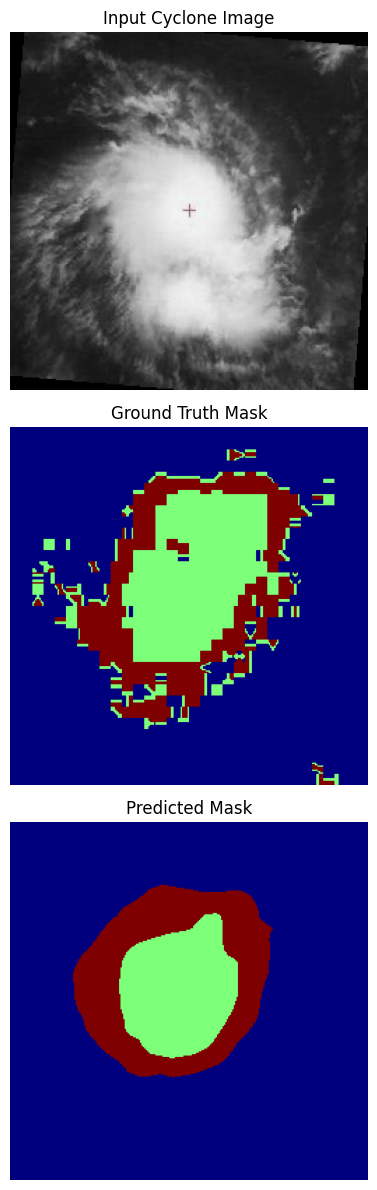

In [ ]:
#test batch
model.eval()
images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

with torch.no_grad():
    outputs = model(images)['out']
    preds = torch.argmax(outputs, dim=1)


images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()


import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].imshow(images[0].permute(1, 2, 0))
axs[0].set_title("Input Cyclone Image")
axs[0].axis("off")

axs[1].imshow(masks[0].squeeze(), cmap="jet", vmin=0, vmax=2)
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

axs[2].imshow(preds[0], cmap="jet", vmin=0, vmax=2)
axs[2].set_title("Predicted Mask")
axs[2].axis("off")

plt.tight_layout()
plt.show()


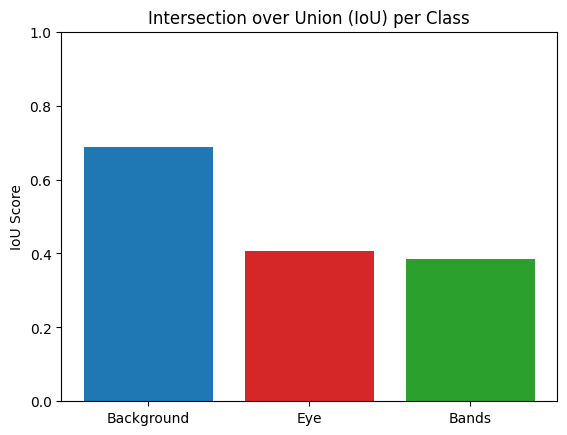

 Classification Report:

              precision    recall  f1-score   support

  Background       0.74      0.90      0.82   4515718
         Eye       0.74      0.47      0.58   2038439
       Bands       0.58      0.53      0.56   2620883

    accuracy                           0.70   9175040
   macro avg       0.69      0.64      0.65   9175040
weighted avg       0.70      0.70      0.69   9175040


 Pixel Accuracy: 0.7017
IoU Scores: Background=0.6890, Eye=0.4073, Bands=0.3844


In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, jaccard_score, accuracy_score
import numpy as np


model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device).squeeze(1).long()

        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(masks.cpu().numpy().flatten())
        y_pred.extend(predictions.cpu().numpy().flatten())


y_true = np.array(y_true)
y_pred = np.array(y_pred)

iou = jaccard_score(y_true, y_pred, average=None, labels=[0, 1, 2])
pixel_acc = accuracy_score(y_true, y_pred)


report = classification_report(y_true, y_pred, labels=[0, 1, 2], output_dict=True)

fig, ax = plt.subplots()
ax.bar(["Background", "Eye", "Bands"], iou, color=["#1f77b4", "#d62728", "#2ca02c"])
ax.set_ylim(0, 1)
ax.set_ylabel("IoU Score")
ax.set_title("Intersection over Union (IoU) per Class")
plt.show()


report_text = classification_report(y_true, y_pred, labels=[0, 1, 2], target_names=["Background", "Eye", "Bands"])
print(" Classification Report:\n")
print(report_text)
print(f"\n Pixel Accuracy: {pixel_acc:.4f}")
print(f"IoU Scores: Background={iou[0]:.4f}, Eye={iou[1]:.4f}, Bands={iou[2]:.4f}")


#**Method 2: U-Net** - Done by Meera

In [60]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

#  Paths from your original code
raw_dataset_path = "/content/drive/MyDrive/Colab Notebooks/insat3d_raw_cyclone_ds"
processed_dataset_path = "/content/drive/MyDrive/Colab Notebooks/ADV_AI_Project/cyclone/processed_cyclone_ds"
images_folder = os.path.join(processed_dataset_path, "images")
masks_folder = os.path.join(processed_dataset_path, "masks")
os.makedirs(images_folder, exist_ok=True)
os.makedirs(masks_folder, exist_ok=True)

#  Data Preprocessing (Modified to create dummy masks)
image_size = (256, 256)
all_images = os.listdir(raw_dataset_path)
image_paths = []
mask_paths = []

for fname in all_images:
    img_path = os.path.join(raw_dataset_path, fname)
    img = Image.open(img_path).convert("RGB").resize(image_size)
    img.save(os.path.join(images_folder, fname))
    image_paths.append(os.path.join(images_folder, fname))

    # Create a dummy mask (all zeros for now - REPLACE THIS WITH YOUR ACTUAL MASK GENERATION)
    mask = Image.new("L", image_size, 0)
    mask_fname = f"{os.path.splitext(fname)[0]}_mask.png"
    mask.save(os.path.join(masks_folder, mask_fname))
    mask_paths.append(os.path.join(masks_folder, mask_fname))

#  Load and Prepare Data for Training
def load_data(image_paths, mask_paths, image_size):
    images = []
    masks = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        img = np.array(Image.open(img_path).convert("RGB")) / 255.0
        mask = np.array(Image.open(mask_path).convert("L")) / 255.0
        mask = np.expand_dims(mask, axis=-1)  # Add channel dimension for binary mask
        images.append(img)
        masks.append(mask)
    return np.array(images), np.array(masks)

images, masks = load_data(image_paths, mask_paths, image_size)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

# U-Net Model Definition
def unet(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = tf.keras.layers.Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = tf.keras.layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9) # Output 2 channels for binary segmentation
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9) # Final 1 channel with sigmoid for probability

    model = Model(inputs=inputs, outputs=conv10)
    return model

#  Compile and Train the Model
model = unet(input_size=(256, 256, 3))
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for saving the best model and early stopping
checkpoint = ModelCheckpoint('unet_cyclone_segmentation.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model
epochs = 30  # Adjust as needed
batch_size = 32 # Adjust as needed

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

#  Evaluate the Model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


# Save the training history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/insat3d_raw_cyclone_ds'

In [49]:
import torch
import matplotlib.pyplot as plt

# Ensure your model is in evaluation mode
model.eval()

# Number of samples to visualize
num_samples = 5

# Get a batch of test samples
data_iter = iter(test_loader)

fig, axes = plt.subplots(num_samples, 3, figsize=(10, 4 * num_samples))

with torch.no_grad():
    for i in range(num_samples):
        try:
            images, masks = next(data_iter)
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            images_cpu = images.cpu().permute(0, 2, 3, 1).squeeze(0)
            masks_cpu = masks.cpu().squeeze(0)
            preds_cpu = preds.cpu().squeeze(0)

            axes[i, 0].imshow(images_cpu)
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(masks_cpu, cmap="jet", vmin=0, vmax=2)
            axes[i, 1].set_title("Ground Truth Mask")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(preds_cpu, cmap="jet", vmin=0, vmax=2)
            axes[i, 2].set_title("Predicted Mask")
            axes[i, 2].axis("off")

        except StopIteration:
            print(f"Warning: Only {i} samples available in the test loader.")
            break

plt.tight_layout()
plt.show()

🚫 X_train is not defined. Please run the data loading cell first.


NameError: name 'X_train' is not defined

In [ ]:
# Step 9: Visualize Training History
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(existing_history.history['loss'], label='Existing Model Train Loss')
plt.plot(existing_history.history['val_loss'], label='Existing Model Val Loss')
plt.plot(unet_history.history['loss'], label='U-Net Train Loss')
plt.plot(unet_history.history['val_loss'], label='U-Net Val Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(existing_history.history['accuracy'], label='Existing Model Train Accuracy')
plt.plot(existing_history.history['val_accuracy'], label='Existing Model Val Accuracy')
plt.plot(unet_history.history['accuracy'], label='U-Net Train Accuracy')
plt.plot(unet_history.history['val_accuracy'], label='U-Net Val Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# Step 10: Evaluate Models on the Test Set
print("\n--- Evaluating Existing Model on Test Set ---")
existing_loss, existing_accuracy = existing_model.evaluate(X_test, y_test, verbose=0)
print(f"Existing Model Test Loss: {existing_loss:.4f}, Test Accuracy: {existing_accuracy:.4f}")

print("\n--- Evaluating U-Net Model on Test Set ---")
unet_loss, unet_accuracy = unet_model.evaluate(X_test, y_test, verbose=0)
print(f"U-Net Model Test Loss: {unet_loss:.4f}, Test Accuracy: {unet_accuracy:.4f}")

def calculate_metrics(model, X, y, num_classes):
    y_pred = model.predict(X)
    y_pred_argmax = np.argmax(y_pred, axis=-1).flatten()
    y_true_argmax = np.argmax(y, axis=-1).flatten()

    iou_scores = jaccard_score(y_true_argmax, y_pred_argmax, labels=range(num_classes), average=None, zero_division=0)
    overall_accuracy = accuracy_score(y_true_argmax, y_pred_argmax)
    report = classification_report(y_true_argmax, y_pred_argmax, labels=range(num_classes), zero_division=0)
    cm = confusion_matrix(y_true_argmax, y_pred_argmax, labels=range(num_classes))
    return iou_scores, overall_accuracy, report, cm

print("\n--- Test Set Metrics for Existing Model ---")
existing_iou, existing_overall_accuracy, existing_report, existing_cm = calculate_metrics(existing_model, X_test, y_test, num_classes)
print("IoU Scores:", existing_iou)
print("Overall Accuracy:", existing_overall_accuracy)
print("Classification Report:\n", existing_report)
disp_existing = ConfusionMatrixDisplay(confusion_matrix=existing_cm, display_labels=["Background", "Eye", "Bands"])
disp_existing.plot(cmap=plt.cm.Blues)
plt.title("Existing Model Confusion Matrix")
plt.show()

print("\n--- Test Set Metrics for U-Net Model ---")
unet_iou, unet_overall_accuracy, unet_report, unet_cm = calculate_metrics(unet_model, X_test, y_test, num_classes)
print("IoU Scores:", unet_iou)
print("Overall Accuracy:", unet_overall_accuracy)
print("Classification Report:\n", unet_report)
disp_unet = ConfusionMatrixDisplay(confusion_matrix=unet_cm, display_labels=["Background", "Eye", "Bands"])
disp_unet.plot(cmap=plt.cm.Blues)
plt.title("U-Net Model Confusion Matrix")
plt.show()


In [ ]:
#  Step 11: Visualize Predictions on the Test Set
def visualize_predictions(model, X, y, num_samples=5, num_classes=3, class_labels=["Background", "Eye", "Bands"]):
    indices = np.random.choice(len(X), num_samples, replace=False)
    test_images = X[indices]
    test_masks = y[indices]
    predicted_masks = model.predict(test_images)
    predicted_masks_argmax = np.argmax(predicted_masks, axis=-1)
    test_masks_argmax = np.argmax(test_masks, axis=-1)

    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(test_images[i])
        plt.title("Input Image")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(test_masks_argmax[i], cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(predicted_masks_argmax[i], cmap='viridis', vmin=0, vmax=num_classes - 1)
        plt.title("Predicted Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n--- Visualizing Predictions (Existing Model) ---")
visualize_predictions(existing_model, X_test, y_test)

print("\n--- Visualizing Predictions (U-Net Model) ---")
visualize_predictions(unet_model, X_test, y_test)

# Step 12: Create Comparison Figures (IoU Bar Chart)
iou_labels = ["Background", "Eye", "Bands"]
x = np.arange(len(iou_labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, existing_iou, width, label='Existing Model')
rects2 = ax.bar(x + width/2, unet_iou, width, label='U-Net')

ax.set_ylabel('IoU Score')
ax.set_title('IoU Score per Class')
ax.set_xticks(x)
ax.set_xticklabels(iou_labels)
ax.legend()

fig.tight_layout()
plt.show()

#**Analysis of Models** - Done by Meera & Annaliese